In [72]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import folium
from shapely.geometry import LineString
from folium import Map, PolyLine
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle


In [4]:
import geopandas as gpd

# Load saved edges GeoDataFrame
edges = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/edges_roads_with_curvature.gpkg", layer='edges')
nodes = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/nodes_roads_with_curvature.gpkg", layer='nodes')

edges.set_index(['u', 'v', 'key'], inplace=True)
nodes.set_index(['osmid'], inplace=True)
# Reconstruct the graph
G = ox.graph_from_gdfs(nodes, edges)
start_lat = 53.1701   # Parsley Hay Car Park lat
start_lon = -1.7816  # Parsley Hay Car Park lon

start_node = ox.nearest_nodes(G, start_lon, start_lat)

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
C:\Users\khong\AppData\Local\Temp\ipykernel_14224\1545879209.py:4: SyntaxWarning: invalid escape sequence '\k'
  edges = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/edges_roads_with_curvature.gpkg", layer='edges')
C:\Users\khong\AppData\Local\Temp\ipykernel_14224\1545879209.py:5: SyntaxWarning: invalid escape sequence '\k'
  nodes = gpd.read_file("C://Users\khong\Documents\Python Projects\Drive\Drive\data/nodes_roads_with_curvature.gpkg", layer='nodes')


In [ ]:
def curvature_weighted_dfs(G, start_node, target_distance=2000, max_depth=20, top_k=2, max_paths=1000):
    stack = [([start_node], 0)]
    outbound_paths = []

    while stack and len(outbound_paths) < max_paths:
        new_stack = stack
        stack = []
        for option in new_stack:
            path, total_length = option
            current_node = path[-1]

            if total_length >= target_distance or len(path) > max_depth:
                outbound_paths.append((path, total_length))
                continue

            candidates = []

            for neighbor in G.successors(current_node):
                if neighbor in path:
                    continue  # avoid node re-use

                for key, data in G[current_node][neighbor].items():
                    length = data.get("length", 0)
                    curvature = data.get("curvature", 0)
                    score = (curvature+0.01) * length
                    candidates.append((score, neighbor, length))

            # Sort and take top-k
            candidates.sort(reverse=True)
            top_choices = candidates[:top_k]

            for _, next_node, edge_length in top_choices:
                new_path = path + [next_node]
                new_total_length = total_length + edge_length
                stack.append((new_path, new_total_length))

    return outbound_paths

outbound_paths = curvature_weighted_dfs(G, start_node, target_distance=15000, max_depth=30, top_k=2, max_paths=4000)
print("Number of paths found:", {len(outbound_paths)})

Number of loops found: {6213}


In [23]:
def analyze_path_metrics(G, path):
    total_length = 0
    curvatures = []
    speedlims = []
    road_names = set()

    for u, v in zip(path[:-1], path[1:]):
        if G.has_edge(u, v):
            # For MultiDiGraph, get all edges between u and v
            edge_data = G.get_edge_data(u, v)
            if edge_data:
                # Choose edge with maximum curvature * length
                best_key = max(
                    edge_data,
                    key=lambda k: edge_data[k].get('curvature', 0) * edge_data[k].get('length', 0)
                )
                data = edge_data[best_key]

                total_length += data.get("length", 0)
                curvatures.append(data.get("curvature", 0))

                # Get speed limit
                speed_limit = data.get("maxspeed")
                if isinstance(speed_limit, str):
                    try:
                        speedlims.append(int(speed_limit.removesuffix(' mph')))
                    except:
                        speedlims.append(30)
                elif speed_limit is None:
                    speedlims.append(30)

                # Add road name(s) to set (can be list or string)
                name = data.get("name")
                if isinstance(name, list):
                    road_names.update(name)
                elif isinstance(name, str):
                    road_names.add(name)
                elif name is None:
                    road_names.add(data.get("osmid"))
        else:
            print(f"Warning: no edge from {u} to {v}")

    avg_curvature = sum(curvatures) / len(curvatures) if curvatures else 0
    num_unique_roads = len(road_names) / len(path)
    avg_speed = sum(speedlims) / len(speedlims)

    # calculate bearing relative to start point
    node_centroid = (np.average(nodes[nodes.index.isin(path)]['y']), np.average(nodes[nodes.index.isin(path)]['x']))
    bearing = np.atan2((node_centroid[0]-start_lat), (node_centroid[1]-start_lon))

    return {
        "total_length": total_length,
        "avg_curvature": avg_curvature,
        "num_unique_roads": num_unique_roads,
        "avg_speed": avg_speed,
        "bearing": bearing
    }


In [24]:
calcs = []
for idx, path in enumerate([i[0] for i in outbound_paths]):
    a = analyze_path_metrics(G, path)
    a['path_id'] = idx
    calcs.append(a)


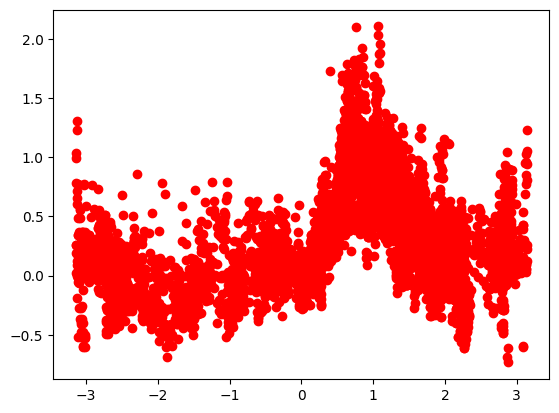

In [27]:
curvature_vector = [i['avg_curvature'] for i in calcs]
roadnumber_vector = [i['num_unique_roads'] for i in calcs]
speed_vector = [i['avg_speed'] for i in calcs]
bearing_vector = [i['bearing'] for i in calcs]

def normalize_vector(vec):
    vec = np.array(vec)
    return (vec - vec.min()) / (vec.max() - vec.min()) if vec.max() > vec.min() else np.zeros_like(vec)

curvature_vector_norm = normalize_vector(curvature_vector)
roadnumber_vector_norm = normalize_vector(roadnumber_vector)
speed_vector_norm = normalize_vector(speed_vector)
score_vector = 2*curvature_vector_norm - roadnumber_vector_norm + speed_vector_norm

plt.plot(bearing_vector, score_vector, 'ro')

results = pd.DataFrame(
    {
        'path_id': [i['path_id'] for i in calcs],
        'avg_curvature': [i['avg_curvature'] for i in calcs],
        'road_uniqueness': [i['num_unique_roads'] for i in calcs],
        'speed': [i['avg_speed'] for i in calcs],
        'bearing': [i['bearing'] for i in calcs],
        'score': score_vector
    }
)


In [63]:
from scipy.signal import find_peaks
analysis_vec = results.sort_values(by='bearing')['score'].values

peaks_idx, _ = find_peaks(analysis_vec, distance=200)  # tune `distance` for diversity

best_paths = results.sort_values(by='bearing').iloc[peaks_idx]

# print(best_paths)
# print(results.sort_values(by='bearing').iloc[peaks_idx]['path_id'].values)

In [67]:
best_outbound = [outbound_paths[i][0] for i in best_paths['path_id'].to_list()]

def get_edges_from_path(G, node_path):
    """
    Given a list of node IDs representing a path, return a list of (u, v, key) edges.
    Assumes G is a MultiDiGraph where multiple edges may exist between nodes.
    """
    edges = []
    for i in range(len(node_path) - 1):
        u = node_path[i]
        v = node_path[i + 1]

        if G.has_edge(u, v):
            # Choose the first matching edge key if multiple exist
            key = list(G[u][v].keys())[0]
            edges.append((u, v, key))
        else:
            print(f"Warning: No edge from {u} to {v} in graph.")
    return edges


def build_return_graph(G, outbound_edges, curvature_weight=1.0, reuse_penalty=1000):
    G_ret = G.copy()
    for u, v, k, data in G_ret.edges(keys=True, data=True):
        base_cost = 1  # or use length, if you want to bias short paths
        curvature = data.get("curvature", 0)
        reuse = (u, v, k) in outbound_edges or (v, u, k) in outbound_edges

        cost = base_cost - curvature_weight * curvature
        if reuse:
            cost += reuse_penalty

        G_ret[u][v][k]["weight"] = max(cost, 0.01)  # prevent zero or negative weights

    return G_ret

full_loops = []
for out_path in best_outbound:
    outbound_edges = get_edges_from_path(G, out_path)
    G_return = build_return_graph(G, outbound_edges)
    return_path = nx.shortest_path(G_return, source=out_path[-1], target=start_node, weight="weight")
    full_loops.append(out_path + return_path[1:])  # skip duplicate end/start node
    
# # Plot full path nodes
# # --- Create Folium map ---
# m = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# # Plot start
# folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='green')).add_to(m)

# # Plot nodes
# for idx, (lat, lon) in enumerate([(data['y'], data['x']) for i, data in nodes[nodes.index.isin(full_loop)].iterrows()], start=1):
#     folium.Marker([lat, lon], popup=f"Waypoint {idx}", icon=folium.Icon(color='blue')).add_to(m)

# # Show map
# m

In [70]:
full_loops

[[324736120,
  27284783,
  27284738,
  243346569,
  27311011,
  27284442,
  493618213,
  493618162,
  319729931,
  460027685,
  460020618,
  27284405,
  442592754,
  367093766,
  367093165,
  478129985,
  478129989,
  247467766,
  27284869,
  243341828,
  27284869,
  243349364,
  27284881,
  27284889,
  243345542,
  243345263,
  243345664,
  1470703951,
  410871345,
  445474955,
  243345684,
  383552225,
  243346291,
  243346282,
  906263267,
  324736120],
 [324736120,
  27284783,
  2386803095,
  27284404,
  2187139036,
  243346569,
  27284738,
  243346282,
  243346291,
  243346213,
  9332725577,
  497966548,
  367118901,
  7997698,
  7997700,
  98234028,
  98234035,
  98234054,
  275363133,
  243347957,
  243347964,
  243347948,
  348772354,
  243347955,
  348841138,
  2393233046,
  243347565,
  414237617,
  439488227,
  243347868,
  282342640,
  448429058,
  6503217967,
  6738345641,
  448429057,
  448429055,
  282342622,
  243348113,
  243348236,
  105870837,
  207262240,
  19762020

In [76]:
loops = full_loops

# --- Create Folium map ---
m = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# Plot start
folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='green')).add_to(m)

def get_color(val, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('viridis')
    rgba = cmap(norm(val))
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

# Color cycle for the paths
colors = cycle(['red', 'blue', 'green', 'purple', 'orange'])

for path in loops:

    path_edges = []

    for u, v in zip(path[:-1], path[1:]):
        # Get all parallel edges between u and v (MultiDiGraph may have >1)
        edge = G.get_edge_data(u, v)
        
        if edge:
            # Select the shortest edge (or first) if multiple exist
            edge_data = min(edge.values(), key=lambda d: d.get('length', float('inf')))
            path_edges.append(edge_data)
            curvature = edge_data.get('curvature', 0)

    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]

    # Add edges to the map
    for row in path_edges:
        if isinstance(row['geometry'], list):
            # Skip any weird geometry
            continue
        # COLOUR CODE by curvature
        # folium.PolyLine(locations=[(lat, lon) for lon, lat in row['geometry'].coords],
        #                 color=get_color(row['curvature'], edges['curvature'].min(), edges['curvature'].max()),
        #                 weight=5).add_to(m)

    # COLOUR CODE by distinct paths
    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(coords, color=next(colors), weight=5, opacity=0.3).add_to(m)

# # Plot nodes
# for idx, (lat, lon) in enumerate([(data['y'], data['x']) for i, data in nodes[nodes.index.isin([loops[0][0]][0])].iterrows()], start=1):
#     folium.Marker([lat, lon], popup=f"Waypoint {idx}", icon=folium.Icon(color='blue')).add_to(m)

# Show map
m

In [130]:
chosen_loop = full_loops[23]

In [131]:
# --- Create Folium map ---
m = folium.Map(location=[start_lat, start_lon], zoom_start=11)

# Plot start
folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='green')).add_to(m)

def get_color(val, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('viridis')
    rgba = cmap(norm(val))
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

for path in [chosen_loop]:

    path_edges = []

    for u, v in zip(path[:-1], path[1:]):
        # Get all parallel edges between u and v (MultiDiGraph may have >1)
        edge = G.get_edge_data(u, v)
        
        if edge:
            # Select the shortest edge (or first) if multiple exist
            edge_data = min(edge.values(), key=lambda d: d.get('length', float('inf')))
            path_edges.append(edge_data)
            curvature = edge_data.get('curvature', 0)

    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]

    # Add edges to the map
    for row in path_edges:
        if isinstance(row['geometry'], list):
            # Skip any weird geometry
            continue
        folium.PolyLine(locations=[(lat, lon) for lon, lat in row['geometry'].coords],
                        color=get_color(row['curvature'], edges['curvature'].min(), edges['curvature'].max()),
                        weight=5).add_to(m)

# # Plot nodes
# for idx, (lat, lon) in enumerate([(data['y'], data['x']) for i, data in nodes[nodes.index.isin([loops[0][0]][0])].iterrows()], start=1):
#     folium.Marker([lat, lon], popup=f"Waypoint {idx}", icon=folium.Icon(color='blue')).add_to(m)

# Show map
m